# Demand Forecasting and Inventory Management

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Show code."></form>''')

## Use case definition
A company opened a challenge on a data science platform to know **which products they should remove from their inventory**. This company have a lot of products in their inventory, and very few of them tend to sell (only about 10% sell each year) and many of the products only have a single sale in the course of a year.

**They asked three questions:**

1. What is the best model to use that will provide us with a probability estimate of a sale for each product? We are mainly interested in a relative unit that we can continuously update based on these attributes (and others that we add, as we are able).

2. Is it possible to provide a scored file (i.e., a probability score for each product in the file), and to provide an evaluation of the accuracy of the selected model?

3. What are the next steps we should take?

I will show you how I solved this use-case and what was my process.

In [3]:
### loading important modules
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.plotting import scatter_matrix

%matplotlib inline
matplotlib.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Input data files are available in the "data/" directory.
# print(os.listdir("data"))

## 1 - Gathering Data
The data set can be collected from various sources such as a file, database, sensor and many other ones. For example, if we want to make a project that uses real-time data, then we can build an IoT system that using different sensors data. 

In this case, company provided a flat file containing both historical data (the sales for the past 6 months) and the active inventory.

Each row on the file represents one product and the most important columns of the dataset are:
- Order: a sequential counter. Can be ignored.
- File_type: if Historical, line is an historical sales else if Active, line is an active invetory one
- SKU_number: unique identifier for each product
- SoldFlag : if 1, product was sold in the past 6 months else if 0, it was not sold
- MarketingType = Two categories of how company markets the product, each type should be considered independently.
- NewReleaseFlag = Any product that has had a future release (i.e., Release Number > 1)

Here are the first lines of this file:

In [5]:
# Reading the dataset
sales_data = pd.read_csv("data/SalesKaggle3.csv")
sales_data.head()

,Order,File_Type,SKU_number,SoldFlag,SoldCount,MarketingType,ReleaseNumber,New_Release_Flag,StrengthFactor,PriceReg,ReleaseYear,ItemCount,LowUserPrice,LowNetPrice
0,2,Historical,1737127,0.0,0.0,D,15,1,682743.0,44.99,2015,8,28.97,31.84
1,3,Historical,3255963,0.0,0.0,D,7,1,1016014.0,24.81,2005,39,0.00,15.54
2,4,Historical,612701,0.0,0.0,D,0,0,340464.0,46.00,2013,34,30.19,27.97
3,6,Historical,115883,1.0,1.0,D,4,1,334011.0,100.00,2006,20,133.93,83.15
4,7,Historical,863939,1.0,1.0,D,2,1,1287938.0,121.95,2010,28,4.00,23.99


## 2 - Data pre-processing
Data pre-processing is one of the most important steps that helps in building machine learning models more accurately. In machine learning, there is an 80/20 rule. Every data scientist should spend 80% time for data pre-processing and 20% time to actually perform the analysis.

Most of the real-world data is messy and certain steps are executed to convert the raw data into a small clean data set, this part of the process is called as data pre-processing. 
Here we will look for:
1. Missing data: this type of data can be found when it is not continuously created or due to technical issues in the application (IoT system).
2. Noisy data: this type of data is also called outliners, this can occur due to human errors (human manually gathering the data) or some technical problem of the device at the time of collection of data.
3. Inconsistent data: this type of data might be collected due to human errors (mistakes with the name or values) or duplication of data. 

### 2.1 - Number of rows and columns in the data set

In [6]:
print('The data set contains', sales_data.shape[0], 'rows and', sales_data.shape[1], 'columns')
print(sales_data[sales_data['File_Type'] == 'Historical']['SKU_number'].count(), 'rows are historical sales')
print(sales_data[sales_data['File_Type'] == 'Active']['SKU_number'].count(), 'rows are active inventory')

The data set contains 198917 rows and 14 columns
75996 rows are historical sales
122921 rows are active inventory


### 2.2 - Type of data
There are three type of data existing:
1. Numeric e.g. income, age
2. Categorical e.g. gender, nationality
3. Ordinal e.g. low/medium/high

In the data set we have 14 columns where 12 are numeric and 2 others are categrorical (File_Type and MarketingType).

In [7]:
#Type of data
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198917 entries, 0 to 198916
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Order             198917 non-null  int64  
 1   File_Type         198917 non-null  object 
 2   SKU_number        198917 non-null  int64  
 3   SoldFlag          75996 non-null   float64
 4   SoldCount         75996 non-null   float64
 5   MarketingType     198917 non-null  object 
 6   ReleaseNumber     198917 non-null  int64  
 7   New_Release_Flag  198917 non-null  int64  
 8   StrengthFactor    198917 non-null  float64
 9   PriceReg          198917 non-null  float64
 10  ReleaseYear       198917 non-null  int64  
 11  ItemCount         198917 non-null  int64  
 12  LowUserPrice      198917 non-null  float64
 13  LowNetPrice       198917 non-null  float64
dtypes: float64(6), int64(6), object(2)
memory usage: 21.2+ MB


### 2.3 - Number of products and unique values for each columns

In [8]:
# 2. Total number of products & unique values of the columns 
print("*****************")
print(sales_data.nunique())
print(sales_data[sales_data['File_Type'] == 'Historical']['SKU_number'].nunique(), 'unique products in historical sales')
print(sales_data[sales_data['File_Type'] == 'Active']['SKU_number'].nunique(), 'unique products in active inventory')

*****************
Order               198917
File_Type                2
SKU_number          133360
SoldFlag                 2
SoldCount               37
MarketingType            2
ReleaseNumber           71
New_Release_Flag         2
StrengthFactor      197424
PriceReg             11627
ReleaseYear             85
ItemCount              501
LowUserPrice         12102
LowNetPrice          15403
dtype: int64
75996 unique products in historical sales
122921 unique products in active inventory


### 2.4 - Descriptives Statistics

Descriptive statistics of the dataset show us the following insights:
- Company has right: ItemCount of each product is very low, meaning many of the products only have a single sale in the historical sales period
- Order and SKU_number show the identifiers so we don't take them into account
- StrenghtFactor and ReleaseNumber are the only variables to have some variability and maybe they could have a role to play for the learning model. Histograms seem to be asymetrics, going more on the left side, so it could be useful to work on these variables.

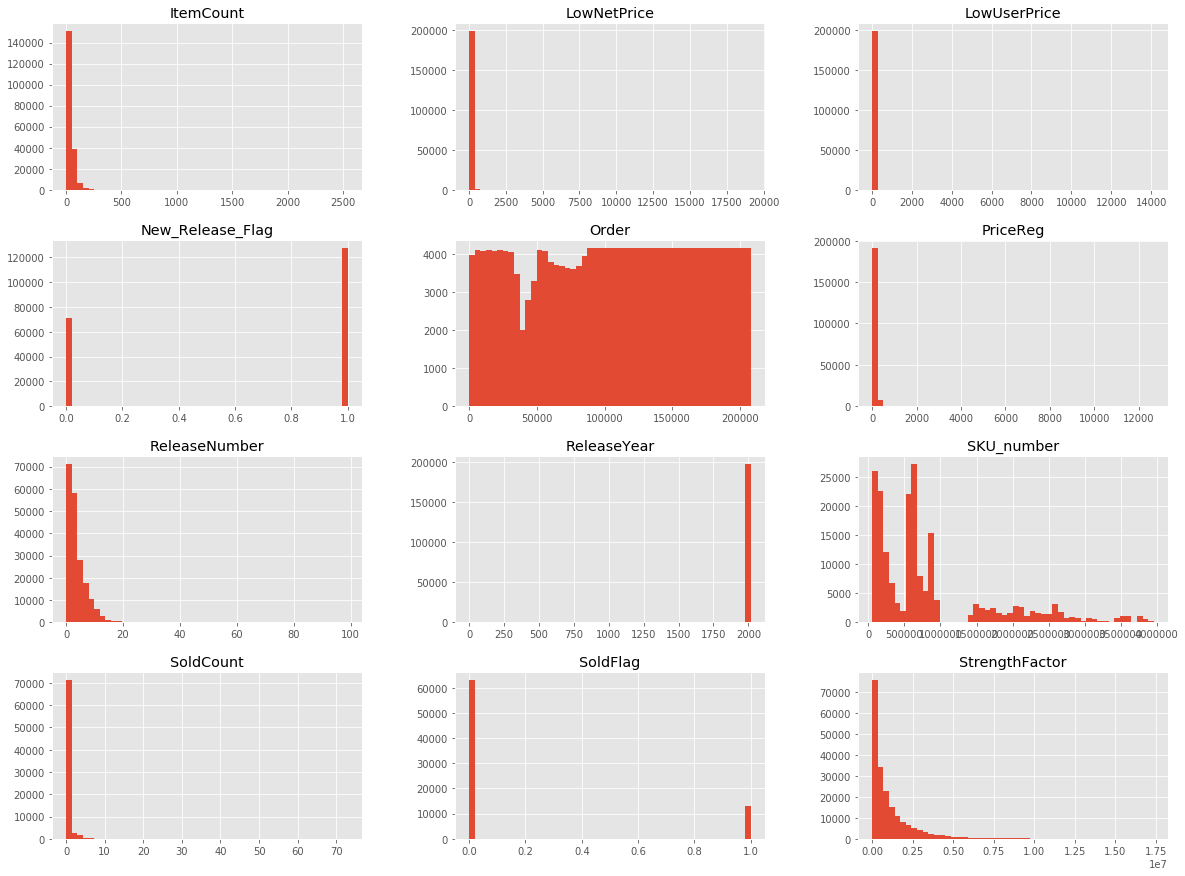

In [9]:
sales_data.hist(bins=50, figsize=(20,15))
plt.show;

### 2.5 - Define target and create a test data set before data exploration
My assumption is to use SoldFlag as the target to predict: meaning if the product was sold or not.

I will not use the active inventory data set as the test one because I don't have the SoldFlag column filled to check if products were sold or not. So I will divided the historical sales data on two data sets, one for train and another one as test. Once I have a model, I will use it on active inventory data to predict what the strategy should be on these products.

My experience learnt me that splitting a data set on train and test datasets, it is one of the most important step in machine learning. One of the main risk is data snooping bias: splitting data set in two and then restarting the program each time will allows the program to discove all the data. To avoid this, I could select some specific rows to put on the test data set. Each time I will launch the program, the same rows will be selected, so my program will never discover these rows. I could easily do that by introducing a row id or better by choosing a feature containing only unique values in the data set. I decided to use the order feature.

Now, I don't want to use some random method to generate my dataset. By using random approach, I could generate a sampling bias. I always prefer to use stratified sampling: the initial population (data set) will be partitioned into subpopulations. The only thing I need to know is which feature I will use as a partitionner. I have seen previously that only two features have some variability: ReleaseNumber and StrengthFactor. I decided to use StrengthFactor feature and I will transform this numerical data into several layers, trying to creating a normal distribution, which is always better for machine learning.

In [10]:
historical_data = sales_data[sales_data['File_Type'] == 'Historical']
active_data = sales_data[sales_data['File_Type'] == 'Active']
#print(historical_data.shape, active_data.shape)

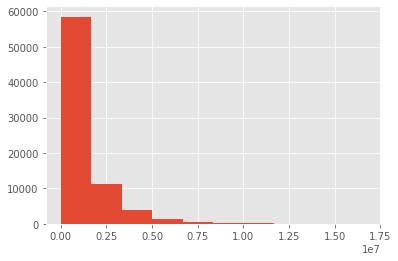

In [11]:
historical_data['StrengthFactor'].hist();

In [12]:
historical_data['StrengthFactor'].describe();

In [13]:
StrengthFactorLayered = pd.cut(historical_data['StrengthFactor'], 
                               bins=[0, 70000, 350000, 1200000, 3000000, 18000000],
                               labels=['verylow','low','middle','strong', 'verystrong'])
StrengthFactorLayered.value_counts(normalize=True);

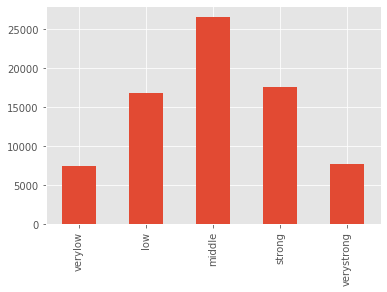

In [14]:
StrengthFactorLayered.value_counts()[['verylow','low','middle','strong', 'verystrong']].plot(kind='bar');

In [15]:
historical_data.insert(8,'StrengthCategories', StrengthFactorLayered)

In [16]:
historical_data.head();

In [17]:
cleanup_categories = {"StrengthCategories": {"verylow": 1, "low": 2, "middle": 3, "strong": 4, "verystrong":5 },
                     "MarketingType" : {"D": 0, "S": 1}}
historical_data.replace(cleanup_categories, inplace=True)
historical_data.head()

,Order,File_Type,SKU_number,SoldFlag,SoldCount,MarketingType,ReleaseNumber,New_Release_Flag,StrengthCategories,StrengthFactor,PriceReg,ReleaseYear,ItemCount,LowUserPrice,LowNetPrice
0,2,Historical,1737127,0.0,0.0,0,15,1,3,682743.0,44.99,2015,8,28.97,31.84
1,3,Historical,3255963,0.0,0.0,0,7,1,3,1016014.0,24.81,2005,39,0.00,15.54
2,4,Historical,612701,0.0,0.0,0,0,0,2,340464.0,46.00,2013,34,30.19,27.97
3,6,Historical,115883,1.0,1.0,0,4,1,2,334011.0,100.00,2006,20,133.93,83.15
4,7,Historical,863939,1.0,1.0,0,2,1,4,1287938.0,121.95,2010,28,4.00,23.99


Now we are ready to do a stratified sampling on this data set in order to split it into train and test dataset.

In [18]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(historical_data, historical_data['StrengthCategories']):
    strat_train_set = historical_data.loc[train_index] 
    strat_test_set = historical_data.loc[test_index]

We will verify if train and test data sets contain quite the same distribution of strength categories as the original data set:

In [19]:
d = {'original data set distribution': [historical_data[historical_data['StrengthCategories'] == 1]['StrengthCategories'].count()/len(historical_data)*100,
                           historical_data[historical_data['StrengthCategories'] == 2]['StrengthCategories'].count()/len(historical_data)*100,
                           historical_data[historical_data['StrengthCategories'] == 3]['StrengthCategories'].count()/len(historical_data)*100,
                           historical_data[historical_data['StrengthCategories'] == 4]['StrengthCategories'].count()/len(historical_data)*100,
                           historical_data[historical_data['StrengthCategories'] == 5]['StrengthCategories'].count()/len(historical_data)*100],
     'train data set distribution': [strat_train_set[strat_train_set['StrengthCategories'] == 1]['StrengthCategories'].count()/len(strat_train_set)*100,
                        strat_train_set[strat_train_set['StrengthCategories'] == 2]['StrengthCategories'].count()/len(strat_train_set)*100,
                        strat_train_set[strat_train_set['StrengthCategories'] == 3]['StrengthCategories'].count()/len(strat_train_set)*100,
                        strat_train_set[strat_train_set['StrengthCategories'] == 4]['StrengthCategories'].count()/len(strat_train_set)*100,
                        strat_train_set[strat_train_set['StrengthCategories'] == 5]['StrengthCategories'].count()/len(strat_train_set)*100],
     'test data set distribution': [strat_test_set[strat_test_set['StrengthCategories'] == 1]['StrengthCategories'].count()/len(strat_test_set)*100,
                       strat_test_set[strat_test_set['StrengthCategories'] == 2]['StrengthCategories'].count()/len(strat_test_set)*100,
                       strat_test_set[strat_test_set['StrengthCategories'] == 3]['StrengthCategories'].count()/len(strat_test_set)*100,
                       strat_test_set[strat_test_set['StrengthCategories'] == 4]['StrengthCategories'].count()/len(strat_test_set)*100,
                       strat_test_set[strat_test_set['StrengthCategories'] == 5]['StrengthCategories'].count()/len(strat_test_set)*100]}
df = pd.DataFrame(data=d)
df

,original data set distribution,train data set distribution,test data set distribution
0,9.717617,9.717745,9.717105
1,22.089320,22.088624,22.092105
2,34.918943,34.918416,34.921053
3,23.113059,23.113363,23.111842
4,10.161061,10.161853,10.157895


## 3 - Data exploration and Feature engineering
Now I have my test data set, I could start exploring data but only on my train data set.
So, first thing to do is to create a copy of my train data set to manipulate it without changing the original training one.

In [20]:
historical_copy = strat_train_set.copy()

In [21]:
historical_copy.drop('File_Type', axis=1, inplace=True)
historical_copy.head();

### Feature selection

Feature selection is the first and most important step of model design, reducing the number of input variables allow to:
- reduce overfitting. Selecting the most useful features and less redundant data means less opportunity to make decisions based on noise.
- reduce development and training time. Some predictive modeling problems have a large number of variables that can slow the development and training of models and require a large amount of system memory. Fewer data points will speed up these times.
- improve accuracy of the model. Performance of some models can degrade when including input variables that are not relevant to the target variable. 

There are different ways to do feature selection:
- Missing values: 
    - we should drop variables that have a very high % of missing values, one way to do that is to build a indicator which is # of records with missing values / # of total records
    - we could turn a missingness into a binary feature like 'is missing' or 'not'. so even if we drop the feature itself wemight encode the missingness as a feature.
- Amount of variation: if a feature is mostly the same value then the model not going to learn anything it from it, so we could drop this feature. The concept is to use standard deviation here and to drop features with zero variation.
- Pairwise correlations: if two features are higly correlated we could drop one because it is redundant
- Correlation with the target, if a feature as a very low correlation with the target, we could drop it because it is not going to be sueful for the model. I will discuss that below on Filter feature selection methods with statistical techniques.
- Forward selection, Backward elimination and Stepwise selection: 
    - Forward selection: we start with one feature (the best one based on model accuracy) and we add the next best feature and keep doing that until a threshold is met (number of features we have defined, performance metric, etc..). We could write a loop to do that.
    - Backward elimination: it is essentially the reverse, it is also called Recursive Feature Elimination, and I will discuss it on Wrapper feature selection methods below. Concept is to start wit all variables and drop the least useful variable (based on the smallest drop in model accuracy) and see how 
    - Stepwise slection is a combination of the two approaches. It is similar to forward selection process but a variable can also be dropped if it is deemed as not useful anymore.
- Lasso and Tree based models could be used to do feature selection, I will discuss it on Intrinsic (or Embedded) feature selection methods
- Feature selection could also be doned by dimensionally reduction techniques, such as Principal Component Analysis. But the difference is that feature selection select features to keep or remove from the dataset, whereas dimensionality reduction create a projection of the data resulting in entirely new input features. As such, dimensionality reduction is an alternate to feature selection rather than a type of feature selection.
- It exists other methods such multicollinearity and cluster analysis.    


There are very different techniques to do feature selection and so many ways to think about it. 
- first way to think about feature selection methods are in terms of supervised and unsupervised methods. 

    - When the outcome is ignored during the elimination of features, the technique is called unsupervised. An exemple of an unsupervised technique is a method that remove redundant variables using correlation. 
    
    - Supervised feature selection techniques use the target variable, such as methods that remove irrelevant variables. There are different methods:
        - **Filter feature selection methods:** these methods filter features based on their relationship with the target. There are two techniques to do that:
            - First techniques are statistical techniques to evaluate the relationship between each input variable and the target variable, and these scores are used as the basis to filter those input variables that will be used in the model.The statistical measures used in filter-based feature selection are generally calculated one input variable at a time with the target variable. As such, they are referred to as univariate statistical measures. This may mean that any interaction between input variables is not considered in the filtering process.  The choice of statistical measures is highly dependent upon the variable data types. The more that is known about the data type of a variable, the easier it is to choose an appropriate statistical measure for a filter-based feature selection method. Here are the different statistical measures:
                 - *Numerical Input, Numerical Output:* This is a regression predictive modeling problem with numerical input variables.The most common techniques are to use a correlation coefficient, such as Pearson’s for a linear correlation or rank-based methods, such as Spearman's rank coefficient, for a nonlinear correlation.
                 - *Numerical Input, Categorical Output:* This is a classification predictive modeling problem with numerical input variables. This might be the most common example of a classification problem. The most common techniques are correlation based, although in this case, they must take the categorical target into account. We could use ANOVA correlation coefficient (linear) or Kendall’s rank coefficient (nonlinear). Kendall does assume that the categorical variable is ordinal.
                 - *Categorical Input, Numerical Output:* This is a regression predictive modeling problem with categorical input variables. This is a strange example of a regression problem (e.g. you would not encounter it often). Nevertheless, you can use the same “Numerical Input, Categorical Output” methods (described just above), but in reverse.
                 - *Categorical Input, Categorical Output:* This is a classification predictive modeling problem with categorical input variables. The most common correlation measure for categorical data is the chi-squared test. You can also use mutual information (information gain) from the field of information theory. In fact, mutual information is a powerful method that may prove useful for both categorical and numerical data, e.g. it is agnostic to the data types.
            - Second technique to do feature selection methods is to use the feature importance property of the model. Feature importance gives you a score for each feature of your data, the higher the score more important or relevant is the feature towards your output variable. Feature importance is an inbuilt class that comes with Tree Based Classifiers.
       
        - **Wrapper feature selection methods:** these methods consider the selection of a set of features as a search problem. They create many models with different subsets of input features and select those features that result in the best performing model according to a performance metric. These methods are unconcerned with the variable types, although they can be computationally expensive. That is why it is better to use these methods on small or medium size data set. Recursive Feature Elimination is a good example of a wrapper feature selection method.
        
        - **Intrinsic (or Embedded) feature selection methods:** Some machine learning algorithms could perform feature selection automatically. The model will only include features that help maximize accuracy. Some examples of these algorithms are penalized regression models like Lasso and ensembles of decision trees like random forest.
        
General advices are to try simple techniques to avoid making mistakes and always check if it is helping accuracy or not.

One example of workflow mixing all techniques could be the following one:




Feature selection is linked to the type of problem and types of data. Here we are on a supervised problem with some categorical and numerical data as inputs and categorical one as target.

In [22]:
historical_copy.head(1);

In [23]:
# Building the target serie
y = historical_copy['SoldFlag']
y.head();

In [24]:
# Building a numerical features data set
Xn = historical_copy.iloc[:,8:]
Xn['ReleaseNumber'] = historical_copy['ReleaseNumber']
Xn['SoldCount'] = historical_copy['SoldCount']
Xn.head()

,StrengthFactor,PriceReg,ReleaseYear,ItemCount,LowUserPrice,LowNetPrice,ReleaseNumber,SoldCount
5668,296697.0,159.20,2009,60,112.59,134.68,14,0.0
36179,1203150.0,64.99,2005,23,51.99,59.99,0,1.0
28843,6061893.0,49.95,1999,14,51.99,96.81,1,0.0
70022,2211641.0,21.99,2006,50,4.92,4.00,0,0.0
50765,1128192.0,54.00,2001,25,0.00,35.75,3,0.0


In [25]:
# Building a categorical features data set
Xc = historical_copy.iloc[:,:7]
Xc.drop(['Order','SKU_number','SoldCount','SoldFlag','ReleaseNumber'], axis=1, inplace=True)
Xc['ReleaseYear'] = historical_copy['ReleaseYear']
Xc.head(1)

,MarketingType,New_Release_Flag,ReleaseYear
5668,0,1,2009


### Feature selection: test of different techniques

In [36]:
y = historical_copy['SoldFlag']
X = historical_copy.drop(['SoldFlag', 'Order'], axis=1)
num_feats = 8

### Feature selection using Filter methods 
#### Statistical techniques

##### Input variable = Numerical | Output variable = Numerical

In [37]:
# Pearson correlation
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
cor_support, cor_feature = cor_selector(X, y,num_feats)
print(str(len(cor_feature)), 'selected features')

8 selected features


##### Input variable = Categorical | Output variable = Categorical

In [38]:
# Chi2 feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')
print(chi_feature)

8 selected features
['SKU_number', 'SoldCount', 'MarketingType', 'ReleaseNumber', 'StrengthCategories', 'StrengthFactor', 'PriceReg', 'ItemCount']


In [45]:
# Mutual information for feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import MinMaxScaler

mutual_selector = SelectKBest(score_func=mutual_info_classif, k=num_feats)
mutual_selector.fit(X_norm, y)

mutual_support = mutual_selector.get_support()
mutual_feature = X.loc[:,mutual_support].columns.tolist()
print(str(len(mutual_feature)), 'selected features')
print(mutual_feature)


8 selected features
['SKU_number', 'SoldCount', 'MarketingType', 'StrengthCategories', 'StrengthFactor', 'PriceReg', 'ItemCount', 'LowUserPrice']


#### Feature importance technique

[0.01601711 0.79315207 0.05198492 0.01010015 0.00184049 0.02754075
 0.02283564 0.01408123 0.01194832 0.02493492 0.01341985 0.01214456]


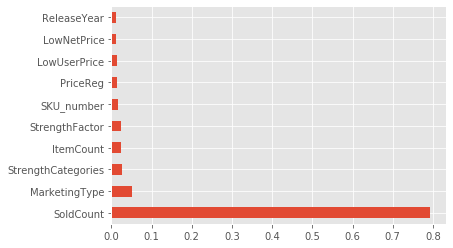

In [39]:
y2 = historical_copy['SoldFlag']
X2 = historical_copy.drop(['SoldFlag', 'Order'], axis=1)

from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X2,y2)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X2.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

### Feature selection using Wrapper method and Recrusrive Feature Elimination

In [40]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')
print(rfe_feature)

Fitting estimator with 12 features.
8 selected features
['SoldCount', 'MarketingType', 'ReleaseNumber', 'StrengthCategories', 'StrengthFactor', 'PriceReg', 'ItemCount', 'LowUserPrice']


### Feature selection using Intrinsic (or Embedded) methods

#### LASSO method

In [41]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=num_feats)
embeded_lr_selector.fit(X_norm, y)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')
print(embeded_lr_feature)

1 selected features
['SoldCount']


#### Random Forest

In [42]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
embeded_rf_selector.fit(X, y)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')
print(embeded_rf_feature)

1 selected features
['SoldCount']


### Putting all methods together

In [43]:
feature_name = X.columns.tolist()

# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name,
                                     'Pearson':cor_support,
                                     'Chi-2':chi_support,
                                     'RFE':rfe_support, 
                                     'Logistics':embeded_lr_support,
                                     'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(num_feats)

,Feature,Pearson,Chi-2,RFE,Logistics,Random Forest,Total
1,SoldCount,True,True,True,True,True,5
2,StrengthFactor,True,True,True,False,False,3
3,StrengthCategories,True,True,True,False,False,3
4,ReleaseNumber,True,True,True,False,False,3
5,PriceReg,True,True,True,False,False,3
6,MarketingType,True,True,True,False,False,3
7,ItemCount,True,True,True,False,False,3
8,SKU_number,True,True,False,False,False,2


### Correlation matrix with heatmap
Correlation states how the features are related to each other or the target variable.
Correlation can be positive (increase in one value of feature increases the value of the target variable) or negative (increase in one value of feature decreases the value of the target variable)
Heatmap makes it easy to identify which features are most related to the target variable.

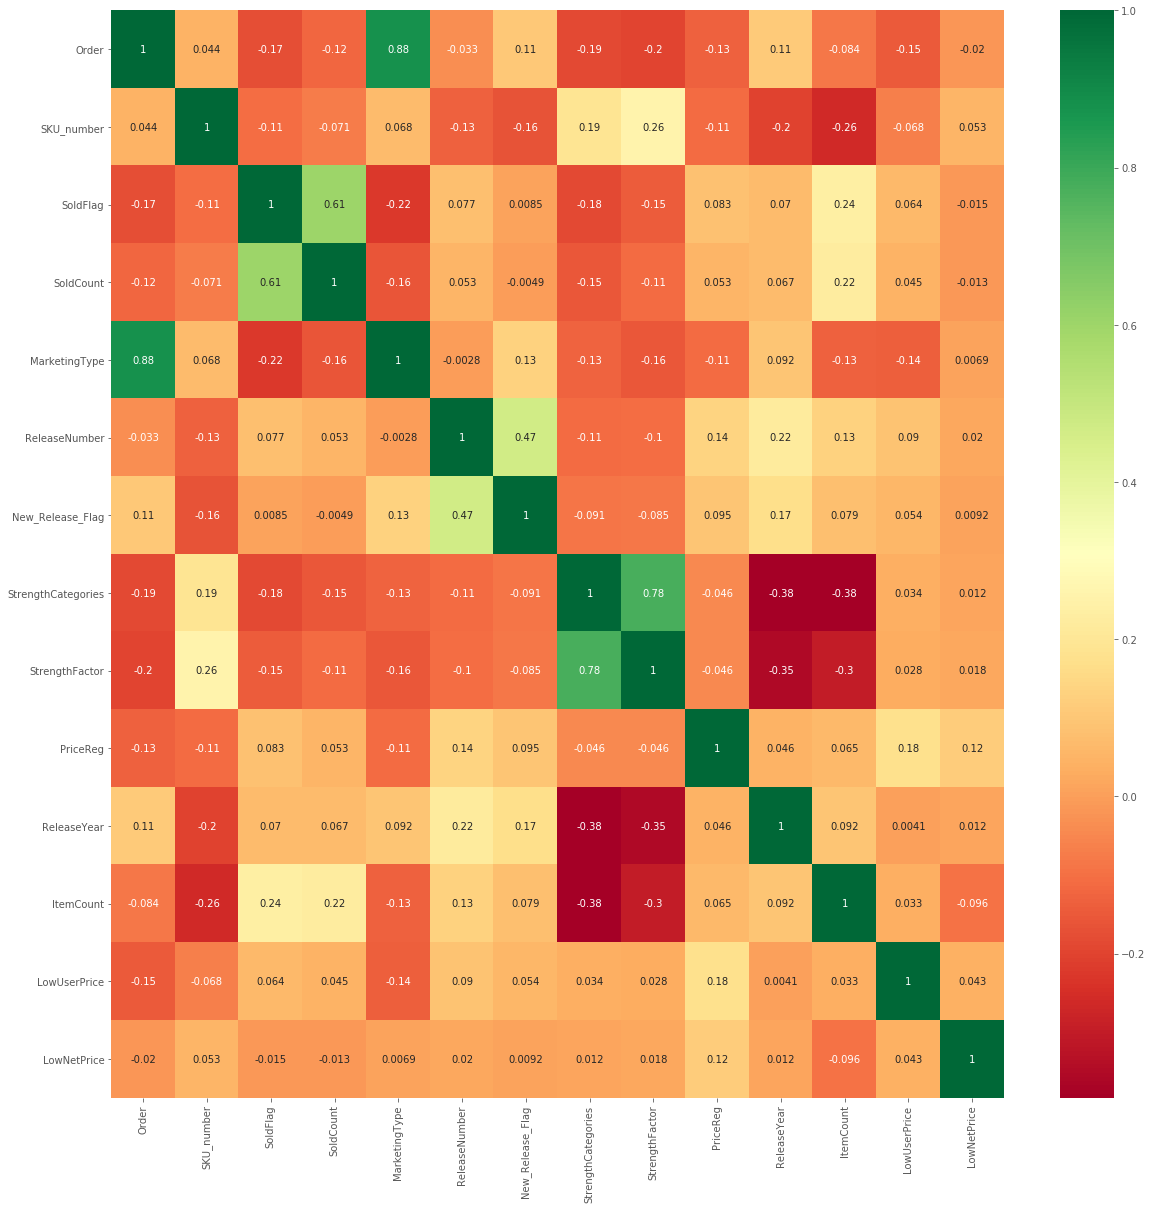

In [35]:
import seaborn as sns
#get correlations of each features in dataset
corr_matrix = historical_copy.corr()
top_corr_features = corr_matrix.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(historical_copy[top_corr_features].corr(),annot=True,cmap="RdYlGn")

Next, we compare the correlation between features and remove features that have a correlation higher than 0.85. By doing that it will remove MarketingType feature.

In [349]:
columns = np.full((corr_matrix.shape[0],), True, dtype=bool)

for i in range(corr_matrix.shape[0]):
    for j in range(i+1, corr_matrix.shape[0]):
        if corr_matrix.iloc[i,j] >= 0.85:
            if columns[j]:
                columns[j] = False
              
selected_columns = historical_copy.columns[columns]
print(historical_copy.columns)
print(selected_columns)

Index(['Order', 'SKU_number', 'SoldFlag', 'SoldCount', 'MarketingType',
       'ReleaseNumber', 'New_Release_Flag', 'StrengthCategories',
       'StrengthFactor', 'PriceReg', 'ReleaseYear', 'ItemCount',
       'LowUserPrice', 'LowNetPrice'],
      dtype='object')
Index(['Order', 'SKU_number', 'SoldFlag', 'SoldCount', 'ReleaseNumber',
       'New_Release_Flag', 'StrengthCategories', 'StrengthFactor', 'PriceReg',
       'ReleaseYear', 'ItemCount', 'LowUserPrice', 'LowNetPrice'],
      dtype='object')


In [350]:
corr_matrix['SoldFlag'].sort_values(ascending=False)

SoldFlag              1.000000
SoldCount             0.605458
ItemCount             0.237854
PriceReg              0.083169
ReleaseNumber         0.077332
ReleaseYear           0.069563
LowUserPrice          0.063706
New_Release_Flag      0.008513
LowNetPrice          -0.015206
SKU_number           -0.107753
StrengthFactor       -0.145335
Order                -0.174724
StrengthCategories   -0.183689
MarketingType        -0.222452
Name: SoldFlag, dtype: float64

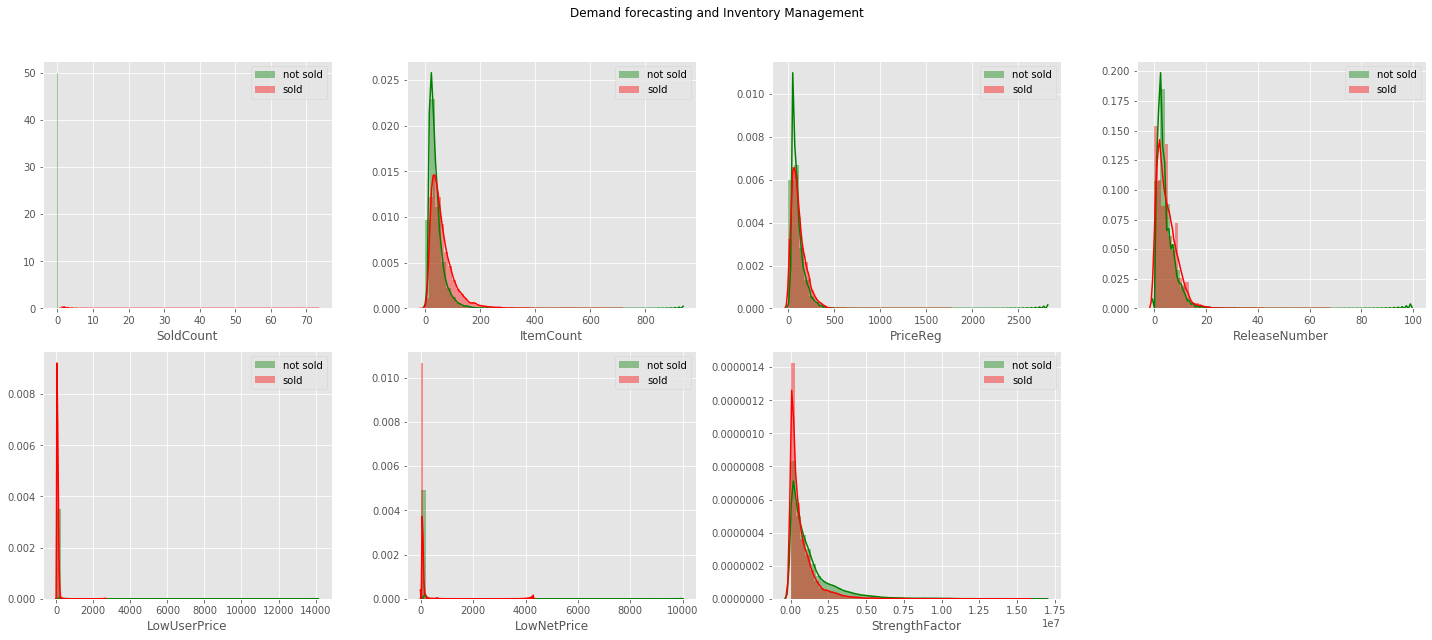

In [351]:
fig = plt.figure(figsize = (20, 25))

result = pd.DataFrame()
result['SoldFlag'] = historical_copy['SoldFlag']

historical_columns = historical_copy[['SoldCount','ItemCount','PriceReg','ReleaseNumber','LowUserPrice',
                                     'LowNetPrice','StrengthFactor']]

j = 0
for i in historical_columns.columns:
    plt.subplot(6, 4, j+1)
    j += 1
    sns.distplot(historical_columns[i][result['SoldFlag']==0], color='g', label = 'not sold')
    sns.distplot(historical_columns[i][result['SoldFlag']==1], color='r', label = 'sold')
    plt.legend(loc='best')
fig.suptitle('Demand forecasting and Inventory Management')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

Once, I have these scores I could go further and select numerical features which seem to be most promizing and cross them through a scatter matrix graph. So I could see which features have some linear correlation with my target. Problem is my target is not a numerical feature: SoldFlag could be 0 or 1. But I could use this approach to look for linear correlation between numerical features, let's have a look on that.

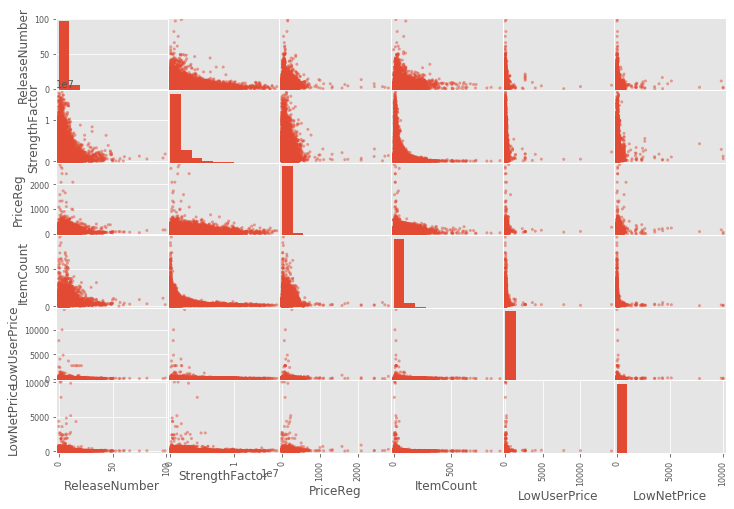

In [352]:
attributes=['ReleaseNumber','StrengthFactor','PriceReg','ItemCount','LowUserPrice','LowNetPrice']
scatter_matrix(historical_copy[attributes], figsize=(12,8));

The histogram above shows the frequency of correlation coefficients among all numerical feature pairs. It shows that the majority of features is only weakly correlated. Nevertheless, there are some features which have an absolut correlation coefficient of more than 0.5. It certainly makes sense to reduce these pairs as they are very unlikely to contribute any further information and are very likely to cause overfitting.

Feature StrengthFactor seems to be correlated with ItemCount, the correlation matrix show us a strong negative correlation between both of them.

In [220]:
corr_matrix['StrengthFactor'].sort_values(ascending=False)

StrengthFactor        1.000000
StrengthCategories    0.778071
SKU_number            0.256797
LowUserPrice          0.027758
LowNetPrice           0.017551
PriceReg             -0.045690
New_Release_Flag     -0.085191
ReleaseNumber        -0.102531
SoldCount            -0.108871
SoldFlag             -0.145335
Order                -0.199224
ItemCount            -0.298706
ReleaseYear          -0.354368
Name: StrengthFactor, dtype: float64

### 4 - Data pre-processing

### 2.4 - Missing values
Next step is to look for missing values on the data set. We have no missing values, except the SoldFlag and SoldCount of the inventory data.

In [181]:
historical_data.isnull().sum()

SKU_number            0
MarketingType         0
ReleaseNumber         0
New_Release_Flag      0
StrengthFactor        0
PriceReg              0
ReleaseYear           0
ItemCount             0
StrengthCategories    0
LowUserPrice          0
LowNetPrice           0
dtype: int64